In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
matplotlib.rcParams.update({"font.size":18})

In [4]:
from numpy.random import normal
import pandas as pd
from tqdm import tqdm
from random import Random

In [4]:
P = array([[0.6, 0.4, 0],[0.6,0.4,0.0],[0.5,0.5,0.0]])

In [3]:
def eiv(P):
    S, U = np.linalg.eig(P.T)
    stationary = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
    stationary = stationary / np.sum(stationary)
    return real(stationary) 

In [578]:
thermal_coefficent = lambda t: 4
temps = lambda t: [environment_temp(t) + thermal_coefficent(t)*q.T.dot(eiv(x)) for x in default_control]
omega = lambda t: [[np.abs(temps(t)[i] - temps(t)[j]) < 2 and temps(t)[i] > 17 and temps(t)[i]<26
                    for j in range(len(default_control))] for i in range(len(default_control))]

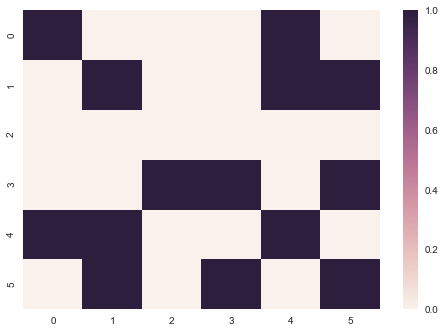

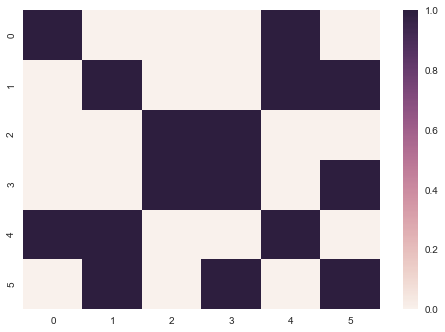

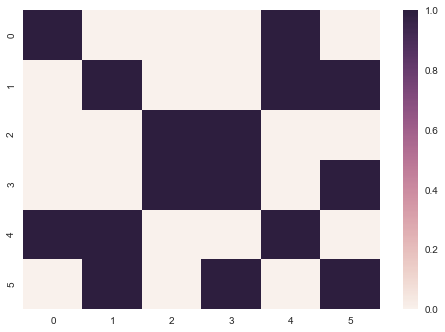

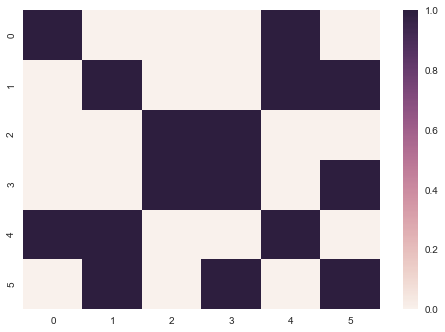

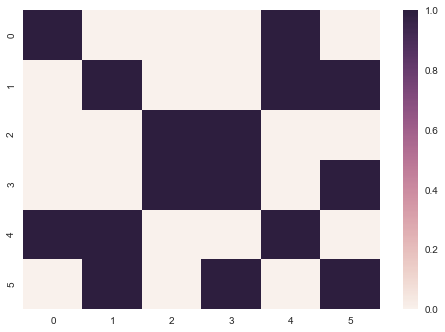

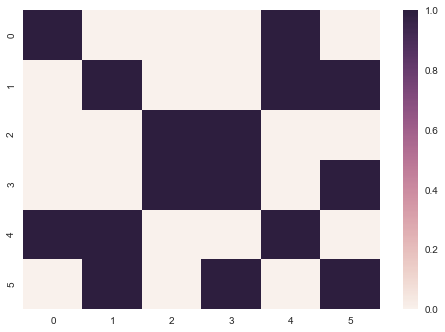

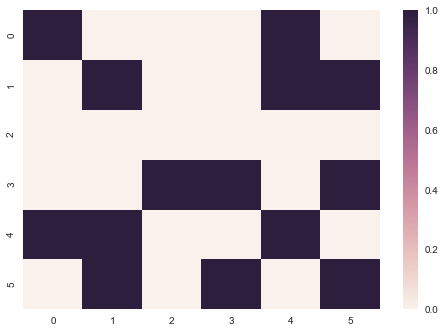

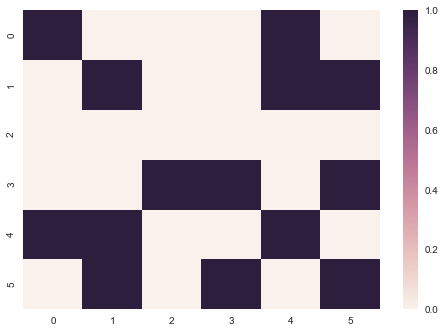

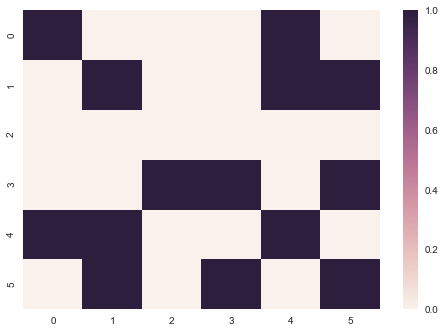

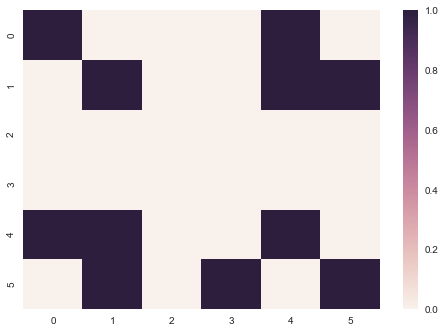

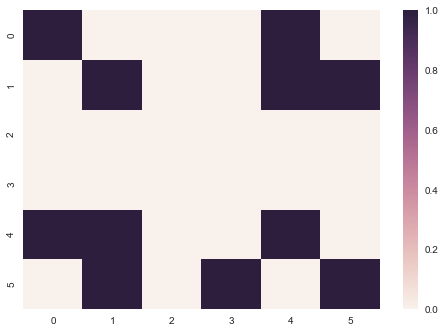

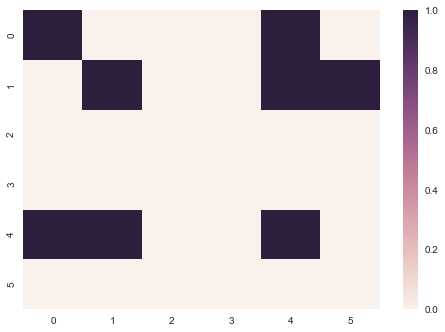

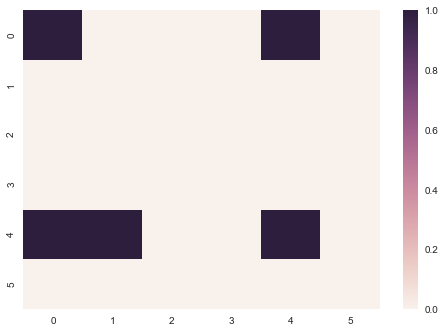

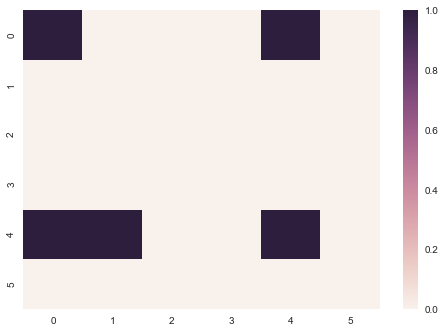

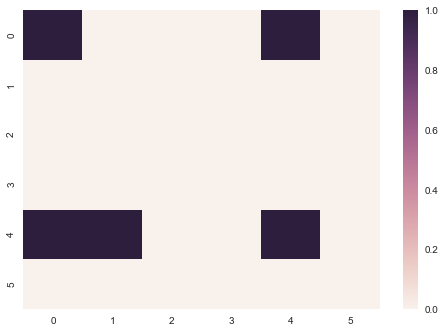

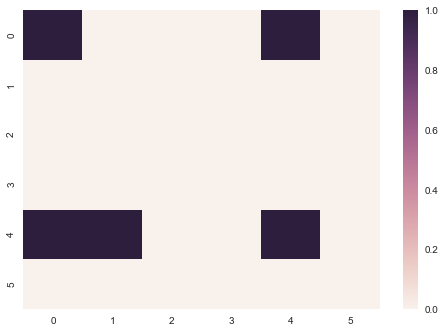

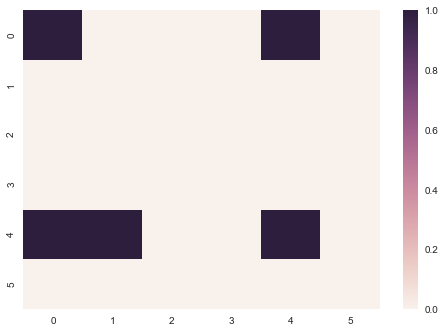

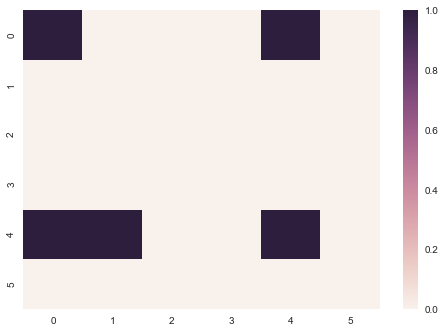

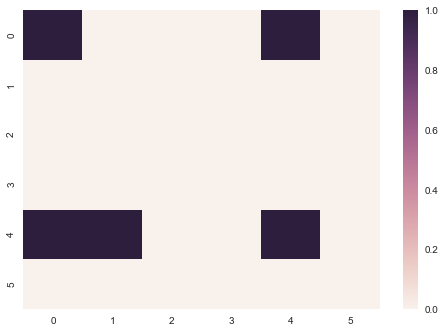

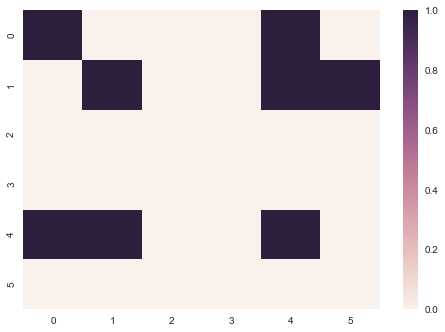

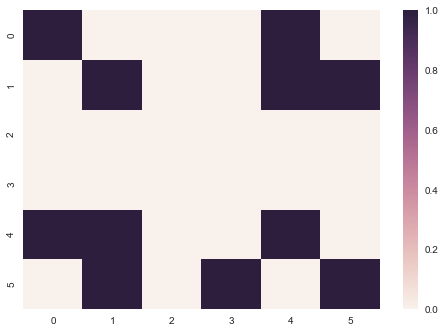

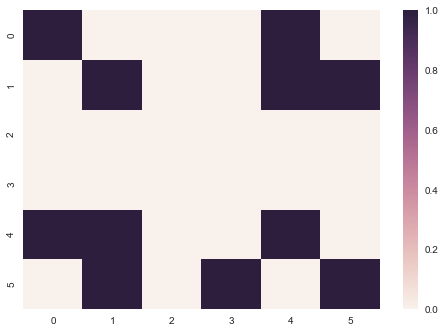

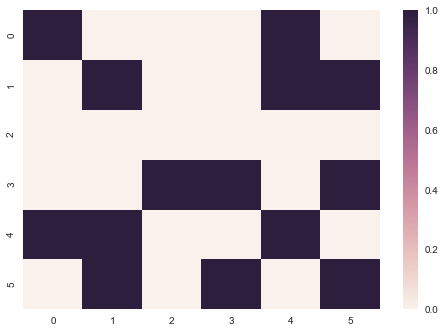

In [86]:
for t in range(23):
    sns.heatmap(model.accept[:, :, t])
    plt.show()

## Emulator Initialisation 

In [8]:
from src.Ensemble import RoomModel, DeviceGenerator, FastAbstractEnsemble, SystemOperator
from src.Ensemble import generate_features, generate_omega_features, learn_regression, learn_omega, eiv
from src.predefined import default_controls as controls
from src.predefined import environment_temp, generation_price, q, default_preference_profile

from sklearn.linear_model import Ridge

random_seed = 43
m = 6
N = 3
n = 300
tau = 2
B = 40000
Q = 1

model = RoomModel(environment_temp, controls, q=q, tau=tau, user_profile=default_preference_profile, omega_is_known=False)
generator = DeviceGenerator(random_seed=random_seed, room_model=model)
ensemble = FastAbstractEnsemble(n, N, m, generator)
operator = SystemOperator(generation_price, 700)

consumption_predictions = []
real_consumptions = []
operator_targets = []
possibly_accepted = []
real_accepted = []
possible_min = []
possible_max = []
budget = []

## My Algorithm (without Knapsack)

In [27]:
gamma = 0.6
beta = 2

u = array([eiv(control) for control in controls])
default_control_dist = array([n/m]*m)
default_pi = 1/n*array([Nj*uj for Nj, uj in zip(default_control_dist, u)]).sum(axis=0)

datasets = [pd.DataFrame(columns=["c%d"%d for d in range(m)] + ['s']) for _ in range(24)]
train = ["c0", "c1", "c2", "c3", "c4", "c5"]
test = ["s"]

classifiers = {}
pi = default_pi

# n_j by defailt
w_last = default_control_dist
np.random.seed(random_seed)

# if omega is not defined
if not hasattr(model, 'accept'):
    # define it randomly
    model.accept = np.random.rand(m, m, 24)
    arm_pulls = np.zeros((m, 24)) + 1

for t in tqdm(range(24*4)):
    time = t%24
    w_prev = classifiers.get(time)
    if w_prev is None:
        w_prev = w_last
        
    target = operator.get_target()
    operator_targets.append(target)
    
    arm_features = [generate_features(pi, model, i, time) for i in range(m+1)]
    maybe_consumptions = array([w_prev.dot(feature) for feature in  arm_features])
    maybe_consumptions_with_variance = maybe_consumptions
    M = max(maybe_consumptions)
    maybe_consumptions_with_variance[1:] -= 1/(beta*M)*sqrt(log(1+t)/arm_pulls[:, time])

    if target == 0 or t < 48:
        arm = 0
        possibly_accepted.append(0)
    else:
        penalties = np.abs([np.inf if x > 0 else -x for x in maybe_consumptions_with_variance - target])
        arm = argmin(penalties)
        possibly_accepted.append(w_prev.dot(model.accept[arm-1, :, time]))
        arm_pulls[arm-1, time] += 1
        
    features = arm_features[arm]

    possible_max.append(max(maybe_consumptions_with_variance))
    possible_min.append(min(maybe_consumptions_with_variance))
    consumption_predictions.append(maybe_consumptions[arm])
    
    ensemble.run(arm)
    
    real_consumption = ensemble.log["total_consumption"][-1]
    real_consumptions.append(real_consumption)
    operator.send_consumption(real_consumption)
    
    
    if arm == 0:
        datasets[time].loc[len(datasets[time])] = features + [real_consumption]
        w_new = learn_regression(np.array(datasets[time][train][-5:]), np.array(datasets[time][test][-5:]), n)    
        classifiers[time] = w_new
    #print("%d:\n %s \n %s \n %s \n"%(t, str(w_prev.astype(int)), str(ensemble.log["control_distribution"]), str(w_new.astype(int))))
    #print("%d: %s \n %s"%(t, str(ensemble.log["state_distribution"]/n), str(pi)))
    else:
        g = generate_omega_features(pi, model, w_prev, arm)
        s = real_consumption - maybe_consumptions[0]
        omega = learn_omega(g.reshape(-1, 1), np.array(s).reshape(-1, 1))
        model.accept[arm-1, :, time] = gamma*omega + (1-gamma)*model.accept[arm-1, :, time]
        
    if arm == 0:
        pi = 1/n*array([N_j*matrix_power(P_j.T, tau).dot(pi) 
                    for N_j, P_j in zip(w_new, model.controls)]).sum(axis=0)
    else:
        pi = 1/n*array([N_j*matrix_power((model.controls[arm-1] if model.accept[arm-1, j, time] else P_j).T, tau).dot(pi) 
                    for N_j, (j, P_j) in zip(w_new, enumerate(model.controls))]).sum(axis=0)
    w_last = w_new 

  9%|▉         | 9/96 [00:02<00:28,  3.07it/s]


KeyboardInterrupt: 

In [6]:
model.accept[:,:, 15]

array([[0.221029  , 0.1809146 , 0.29033278, 0.5696244 , 0.84489789,
        0.72860405],
       [0.1591375 , 0.58973101, 0.89873709, 0.54422628, 0.94441954,
        0.18253548],
       [0.32840069, 0.65576376, 0.29581906, 0.93014119, 0.9932527 ,
        0.30756993],
       [0.95244553, 0.90919798, 0.89679048, 0.85470069, 0.8456701 ,
        0.84944041],
       [0.68684537, 0.63136682, 0.76412689, 0.27492678, 0.22556129,
        0.94892302],
       [0.93972997, 0.87072038, 0.86937808, 0.88257127, 0.31186076,
        0.77712683]])

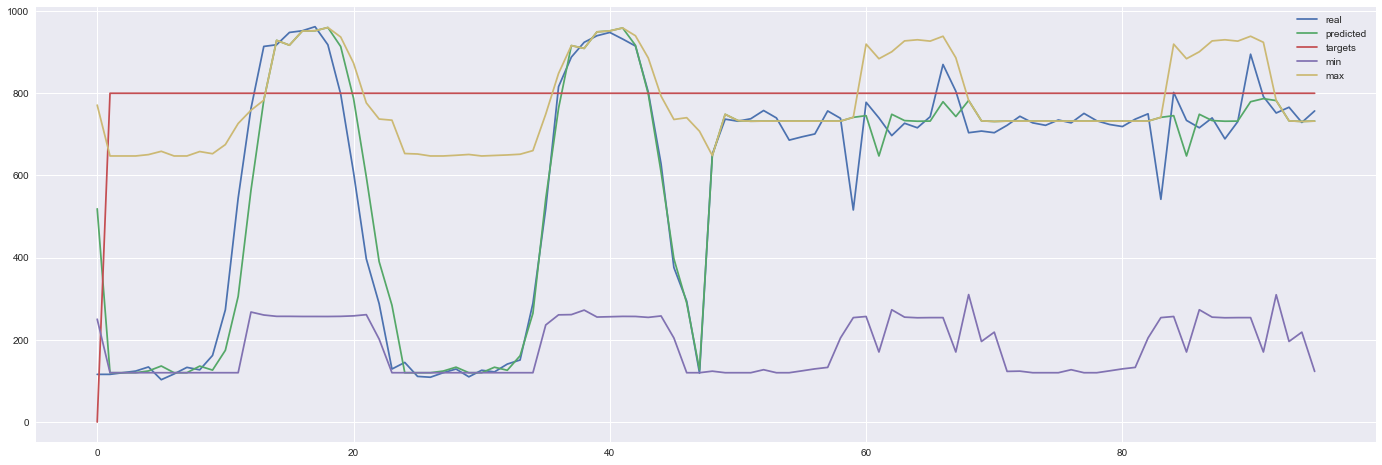

In [7]:
figure(figsize=(24, 8))
plot(real_consumptions[-0:], label="real")
plot(consumption_predictions[-0:], label="predicted")
plot(operator_targets[-0:], label="targets")
plot(possible_min[-0:], label="min")
plot(possible_max[-0:], label="max")
legend()
show()

In [21]:
arm_pulls[3, :]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 1., 3., 3., 3., 3.,
       3., 1., 1., 3., 3., 3., 3.])

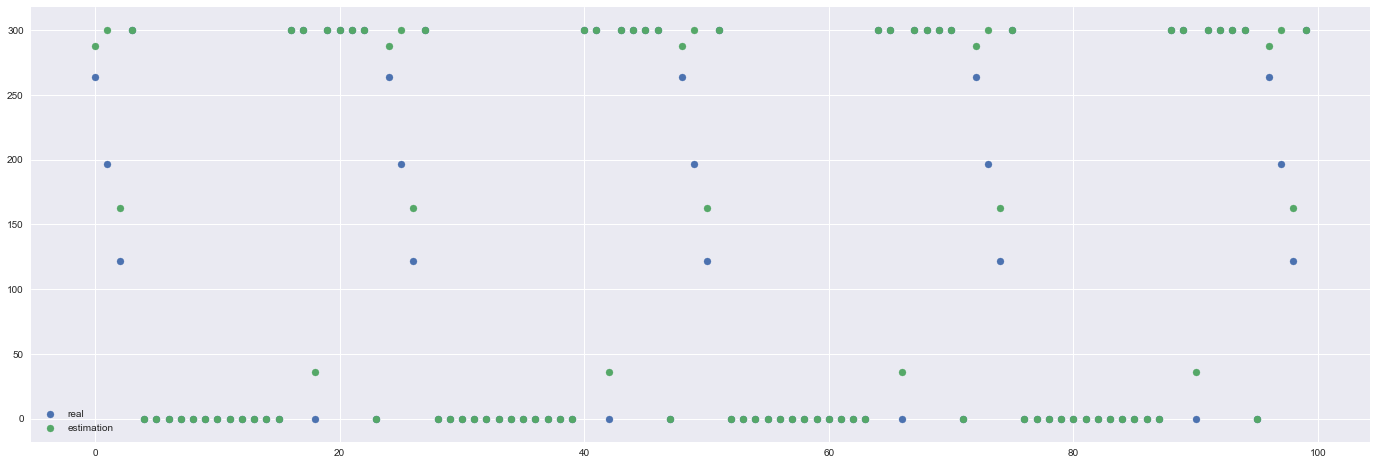

In [16]:
figure(figsize=(24, 8))
scatter(range(len(possibly_accepted[-100:])), ensemble.log["accepted"][-100:], label="real")
scatter(range(len(possibly_accepted[-100:])), possibly_accepted[-100:], label="estimation")
legend()

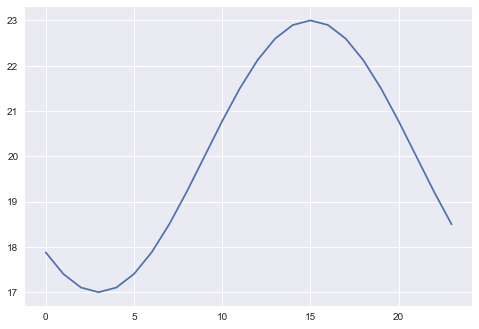

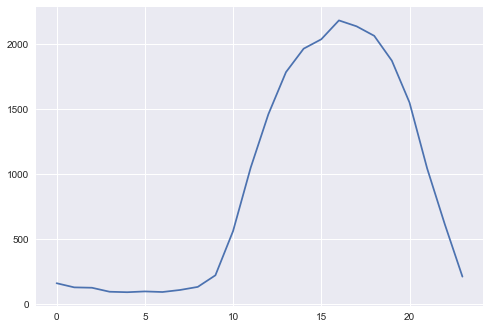

In [589]:
plot([environment_temp(t) for t in range(24)])
show()
plot([generation_price(t)*real_consumptions[t] for t in range(24)])

## PrimalDualBwK (without context and with k(t))

In [6]:
np.random.seed(random_seed)

mean_regret = np.zeros((m+1, 24))
mean_regret[:, :] = 500
mean_participants = np.zeros((m+1, 24))
mean_participants[:, :] = n/3
arm_pulls = np.zeros((m+1, 24)) + 1

delta = 1/10
gamma = 0.8
budget_rest = B

for t in tqdm(range(24*45)):
    time = t%24
    
    target = operator.get_target()
    operator_targets.append(target)
    
    regret = mean_regret[:, time]
    M = max(regret)
    regret_LCB = regret - delta*M*sqrt(2*log(1+t)/arm_pulls[:, time])

    if target == 0 or budget_rest < 0:
        arm = 0
    else:
        penalties = np.abs([np.inf if x > 0 else -x for x in regret_LCB - target]) + exp(1/4*B/budget_rest)*Q*mean_participants[:, time] # ?????? <= check
        arm = argmin(penalties)
        arm_pulls[arm, time] += 1
    consumption_predictions.append(regret_LCB[arm])
    
    ensemble.run(arm)
    
    accepted = ensemble.log["accepted"][-1]
    real_accepted.append(accepted)
    mean_participants[arm, time] = gamma*mean_participants[arm, time] + (1-gamma)*accepted
    
    real_consumption = ensemble.log["total_consumption"][-1]
    real_consumptions.append(real_consumption)
    operator.send_consumption(real_consumption)
    mean_regret[arm, time] = gamma*mean_regret[arm, time] + (1-gamma)*real_consumption
    
    budget_rest -= accepted
    budget.append(budget_rest)

100%|██████████| 1080/1080 [04:54<00:00,  3.67it/s]


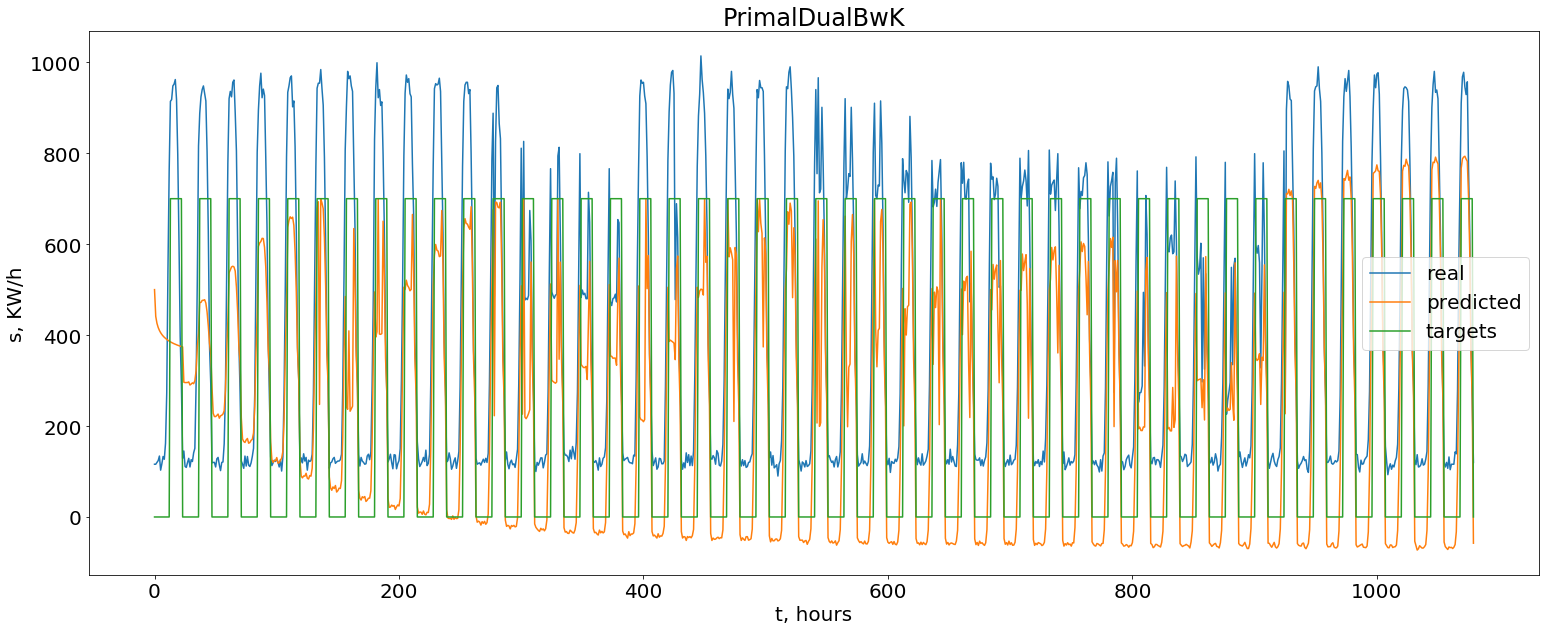

In [7]:
matplotlib.rcParams.update({"font.size":20})
figure(figsize=(26, 10))
plot(real_consumptions, label="real")
plot(consumption_predictions, label="predicted")
plot(operator_targets, label="targets")
legend()
xlabel("t, hours")
ylabel("s, KW/h")
title("PrimalDualBwK")
show()

In [15]:
budget1 = budget

## LinCBwK-inspired

In [9]:
gamma = 0.6
beta = 1/10

u = array([eiv(control) for control in controls])
default_control_dist = array([n/m]*m)
default_pi = 1/n*array([Nj*uj for Nj, uj in zip(default_control_dist, u)]).sum(axis=0)

datasets = [pd.DataFrame(columns=["c%d"%d for d in range(m)] + ['s']) for _ in range(24)]
train = ["c0", "c1", "c2", "c3", "c4", "c5"]
test = ["s"]

classifiers = {}
pi = default_pi

# n_j by defailt
w_last = default_control_dist
np.random.seed(random_seed)

budget_rest = B
# if omega is not defined
if not hasattr(model, 'accept'):
    # define it randomly
    model.accept = np.random.rand(m, m, 24)
    arm_pulls = np.zeros((m, 24)) + 1

for t in tqdm(range(24*45)):
    time = t%24
    w_prev = classifiers.get(time)
    if w_prev is None:
        w_prev = w_last
        
    target = operator.get_target()
    operator_targets.append(target)
    
    arm_features = [generate_features(pi, model, i, time) for i in range(m+1)]
    maybe_consumptions = array([w_prev.dot(feature) for feature in  arm_features])
    maybe_consumptions_with_variance = maybe_consumptions
    M = max(maybe_consumptions)
    maybe_consumptions_with_variance[1:] -= beta*M*sqrt(2*log(1+t)/arm_pulls[:, time])

    if target == 0 or t < 48:
        arm = 0
        possibly_accepted.append(0)
    else:
        penalties = np.abs([np.inf if x > 0 else -x for x in maybe_consumptions_with_variance - target])
        arm = argmin(penalties)
        possibly_accepted.append(w_prev.dot(model.accept[arm-1, :, time]))
        arm_pulls[arm-1, time] += 1
        
    features = arm_features[arm]

    budget.append(budget_rest)
    possible_max.append(max(maybe_consumptions_with_variance))
    possible_min.append(min(maybe_consumptions_with_variance))
    consumption_predictions.append(maybe_consumptions[arm])
    
    ensemble.run(arm)
    budget_rest -= ensemble.log["accepted"][-1]
    real_consumption = ensemble.log["total_consumption"][-1]
    real_consumptions.append(real_consumption)
    operator.send_consumption(real_consumption)
    
    
    if arm == 0 or t < 48:
        datasets[time].loc[len(datasets[time])] = features + [real_consumption]
        w_new = learn_regression(np.array(datasets[time][train][-5:]), np.array(datasets[time][test][-5:]), n)    
        classifiers[time] = w_new
    #print("%d:\n %s \n %s \n %s \n"%(t, str(w_prev.astype(int)), str(ensemble.log["control_distribution"]), str(w_new.astype(int))))
    #print("%d: %s \n %s"%(t, str(ensemble.log["state_distribution"]/n), str(pi)))
    else:
        g = generate_omega_features(pi, model, w_prev, arm)
        s = real_consumption - maybe_consumptions[0]
        omega = learn_omega(g.reshape(-1, 1), np.array(s).reshape(-1, 1))
        model.accept[arm-1, :, time] = gamma*omega + (1-gamma)*model.accept[arm-1, :, time]
        
    if arm == 0:
        pi = 1/n*array([N_j*matrix_power(P_j.T, tau).dot(pi) 
                    for N_j, P_j in zip(w_new, model.controls)]).sum(axis=0)
    else:
        pi = 1/n*array([N_j*matrix_power((model.controls[arm-1] if model.accept[arm-1, j, time] else P_j).T, tau).dot(pi) 
                    for N_j, (j, P_j) in zip(w_new, enumerate(model.controls))]).sum(axis=0)
    w_last = w_new 

100%|██████████| 1080/1080 [08:00<00:00,  2.25it/s]


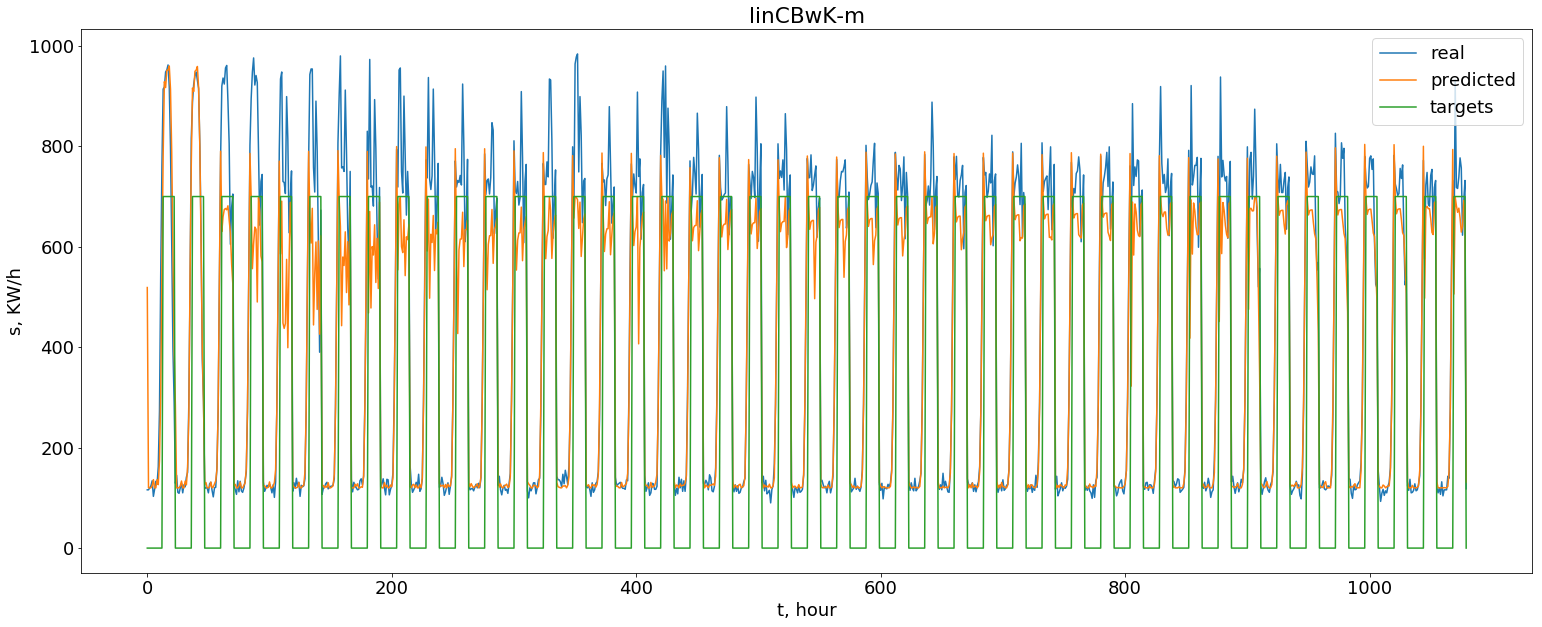

In [10]:
matplotlib.rcParams.update({"font.size":18})
figure(figsize=(26, 10))
plot(real_consumptions, label="real")
plot(consumption_predictions, label="predicted")
plot(operator_targets, label="targets")
legend()
xlabel("t, hour")
ylabel("s, KW/h")
title("linCBwK-m")
show()

In [78]:
real_consumptions2 = real_consumptions

In [83]:
real_consumptions = array(real_consumptions)
real_consumptions2 = array(real_consumptions2)
operator_targets = array(operator_targets)

In [90]:
A = real_consumptions.copy()
B = real_consumptions2.copy()
C = operator_targets.copy()

In [91]:
A[C == 0] = 0
B[C == 0] = 0

In [106]:
dump = {}
dump["lincbwk_budget"] = budget3
dump["pdbwk_budget"] = budget1[:1080]
dump["pdbwk_regret"] = abs(A-C).cumsum()
dump["lincbwk_regret"] = abs(B-C).cumsum()

In [107]:
import pickle

In [110]:
pickle.dump(dump, open("results.dump", 'wb'))

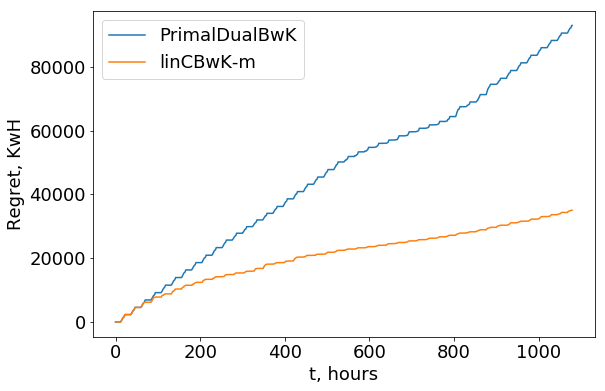

In [111]:
figure(figsize=(9,6))
plot(abs(A-C).cumsum(), label = "PrimalDualBwK")
plot(abs(B-C).cumsum(), label = "linCBwK-m")
xlabel("t, hours")
ylabel("Regret, KwH")
legend()

In [28]:
budget2 = budget - min(budget)
budget2 = budget2*40000/max(budget2)
plot(budget2)

In [69]:
mask = np.array([(1+cos(2*np.pi*x/1080))/2 for x in range(1080)])/3+2/3
budget3=budget2*mask

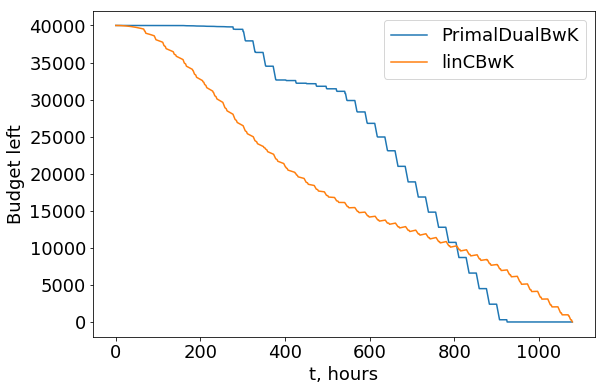

In [77]:
figure(figsize=(9,6))
plot(budget1[:1080], label="PrimalDualBwK")
plot(budget3, label="linCBwK")
xlabel("t, hours")
ylabel("Budget left")
legend()